In [87]:
import numpy as np

import cvxpy as cp
import matplotlib.pyplot as plt
import opt
import sev_filters_opt

In [88]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True, attrs=None):
    # Normalized error
    if Y_test.ndim == 2:
        norm_sq_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_sq_y)
    else:
        norm_y = (Y_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
        err_ys = ((Y_test - Y_hat)**2).sum((1,2)) / norm_y
        err_y = np.mean(err_ys)
    
    if print_results:
        print(f"Error in signal y: {err_y}")
        if Y_test.ndim == 3 and attrs is not None:
            print("Error in each attribute")
            for i in range(Y_test.shape[0]):
                print(f"{attrs[i]} - {err_ys[i]}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_sq_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_sq_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, err_H

    return err_y

In [89]:
def plot_filters(Hs):
    n_filt = Hs.shape[0]
    f, ax = plt.subplots(1, n_filt, figsize=(12,8))

    for i in range(n_filt):    
        ax[i].imshow(Hs[i,:,:])

# Reading the data

In [90]:
#data = np.load('data_temp/temperatures2003_mod_knn8_N40.npz')
data = np.load('data_temp/temperatures2018_knn8_N28.npz') # 54 for only valid values, 36 for invalid values as well

# Multiple filters for multiple data

In [91]:
A = data['A_bin']
attrs = ["Temperatures",
"Precipitation",
#"Wind Speed",
"Station Pressure"
]
X1 = data['temps']
X2 = data['precs']
X3 = data['windsps']
X4 = data['press']
comp_data = np.array([
    X1,
    X2,
#    X3,
    X4
])
n_feat, N, N_dates = comp_data.shape
N_dates -= 1

Ys = comp_data[:,:,1:].copy()
Xs = comp_data[:,:,:-1].copy()
Xs.shape, Ys.shape

((3, 28, 364), (3, 28, 364))

In [92]:
train_test_split = 0.7#1/6

random_train_test = False
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

Xs_train = Xs[:,:,idxs_train]
Ys_train = Ys[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Ys_test = Ys[:,:,idxs_test]
Xs_train.shape, Ys_train.shape, Xs_test.shape, N_dates

((3, 28, 254), (3, 28, 254), (3, 28, 110), 364)

In [93]:
models = []
errs_y = []
errs_H = []

In [94]:
Hs_gt = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_test[i,:,:] - H @ Xs_test[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_gt.append(H.value)
Hs_gt = np.array(Hs_gt)

In [95]:
Ys_hat_gt = Hs_gt @ Xs_test
err_y_gt, err_H_gt = error_metrics(Ys_hat_gt, Ys_test, Hs_gt, Hs_gt, attrs=attrs)
models.append("Least Squares (LB)"); errs_y.append(err_y_gt); errs_H.append(err_H_gt)
err_y_gt, err_H_gt

Error in signal y: 0.15738556430618236
Error in each attribute
Temperatures - 0.0043439133076211105
Precipitation - 0.45520019803484935
Station Pressure - 0.012612581576076596
Error in filter: 0.0


(0.15738556430618236, 0.0)

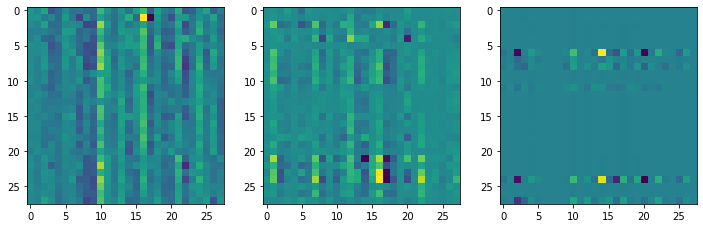

In [96]:
plot_filters(Hs_gt)

# Eye model

In [97]:
# Identity - copying the temperature from the previous day
Hs_eye = np.array([np.eye(N) for _ in range(n_feat)])
Ys_eye = Hs_eye @ Xs_test
err_y_eye, err_H_eye = error_metrics(Ys_eye, Ys_test, Hs_eye, Hs_gt, attrs=attrs)
models.append("Copy Prev Day"); errs_y.append(err_y_eye); errs_H.append(err_H_eye)

Error in signal y: 0.41451632005316297
Error in each attribute
Temperatures - 0.008266568860983472
Precipitation - 1.198852349731437
Station Pressure - 0.03643004156706837
Error in filter: 1.0481309731352624


## Least squares

In [98]:
Hs_ls = []
for i in range(n_feat):
    H = cp.Variable((N,N))
    obj = cp.sum_squares(Ys_train[i,:,:] - H @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    Hs_ls.append(H.value)
Hs_ls = np.array(Hs_ls)

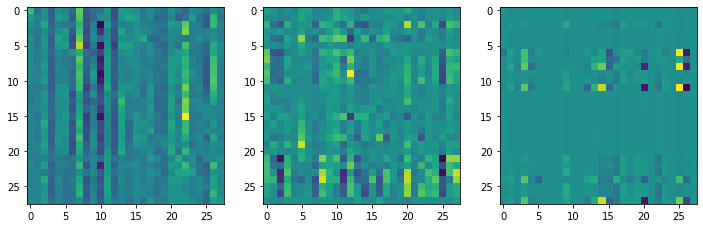

In [99]:
plot_filters(Hs_ls)

In [100]:
Ys_hat_ls = Hs_ls @ Xs_test
err_y_ls, err_H_ls = error_metrics(Ys_hat_ls, Ys_test, Hs_ls, Hs_gt, attrs=attrs)
models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)
err_y_ls, err_H_ls

Error in signal y: 0.3633519537249756
Error in each attribute
Temperatures - 0.010723599105279511
Precipitation - 1.044581857786537
Station Pressure - 0.03475040428311042
Error in filter: 1.4718416400664103


(0.3633519537249756, 1.4718416400664103)

In [101]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
Hs_ls_gf = []
for i in range(n_feat):
    h = cp.Variable(K)
    obj = cp.sum_squares(Ys_train[i,:,:] - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ Xs_train[i,:,:])
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    h = h.value
    Hs_ls_gf.append(np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0))
Hs_ls_gf = np.array(Hs_ls_gf)

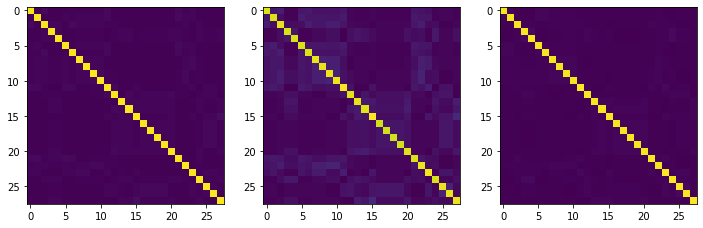

In [102]:
plot_filters(Hs_ls_gf)

In [103]:
Ys_hat_ls_gf = Hs_ls_gf @ Xs_test
err_y_ls_gf, err_H_ls_gf = error_metrics(Ys_hat_ls_gf, Ys_test, Hs_ls, Hs_gt, attrs=attrs)
models.append("LS-GF"); errs_y.append(err_y_ls_gf); errs_H.append(err_H_ls_gf)
err_y_ls_gf, err_H_ls_gf

Error in signal y: 0.28675364135140907
Error in each attribute
Temperatures - 0.008089990602599744
Precipitation - 0.8165339694219764
Station Pressure - 0.035636964029650976
Error in filter: 1.4718416400664103


(0.28675364135140907, 1.4718416400664103)

## Iterative (robust) algorithms

In [104]:
args = [0.4, 0.008, 0.0005, 3.]
args_no_st = [0.03, 0.005, 0., 3.5]
args_rew = [0.2, 0.1, 0.001, 0.0001, 1.1]
args_rew_no_st = [0.1, 0.08, 0., 5e-4, 1.]

In [105]:
meanX = comp_data.mean(2)
stdX = comp_data.std(2)
Cs = np.zeros((n_feat, N, N))
for i in range(n_feat):
    X_norm = (comp_data[i,:,:].T - meanX[i,:]) / stdX[i,:]

    X_norm = np.where(np.isnan(X_norm), comp_data[i,:,:].T, X_norm)
    
    Cs[i,:,:] = np.cov(X_norm.T)

In [106]:
Hs_iter = []
for i in range(n_feat):
    _, H, _ = opt.estH_iter(Xs[i,:,:], Ys[i,:,:], A, Cs[i,:,:], args)
    Hs_iter.append(H)
Hs_iter = np.array(Hs_iter)

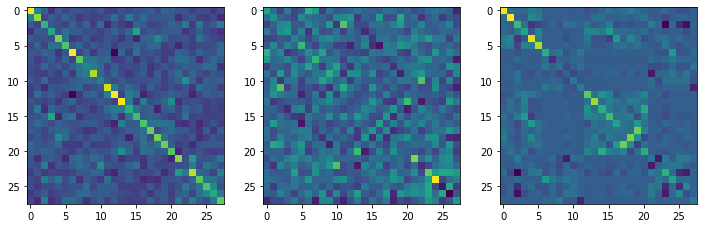

In [107]:
plot_filters(Hs_iter)

In [108]:
Ys_hat_iter = Hs_iter @ Xs_test
err_ys_iter, err_Hs_iter = error_metrics(Ys_hat_iter, Ys_test, Hs_iter, Hs_gt, attrs=attrs)
models.append("RGFI"); errs_y.append(err_ys_iter); errs_H.append(err_Hs_iter)
err_ys_iter, err_Hs_iter

Error in signal y: 0.26602542505180776
Error in each attribute
Temperatures - 0.007216230201197468
Precipitation - 0.7668126859043746
Station Pressure - 0.024047359049851263
Error in filter: 0.986472589248872


(0.26602542505180776, 0.986472589248872)

## Iterative joint algs

In [109]:
import sev_filters_opt

In [110]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [111]:
iter, Hs_iter_j, S_iter_j = sev_filters_opt.estHs_iter(Xs_train, Ys_train, A, Cs, args)

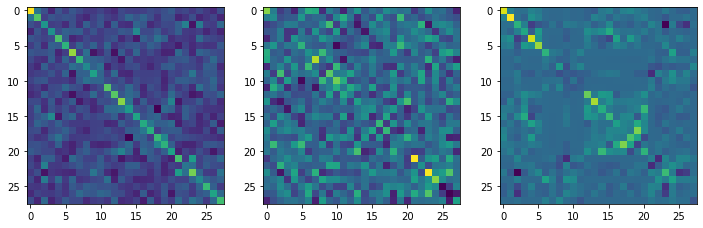

In [112]:
plot_filters(Hs_iter_j)

In [113]:
Ys_hat_iter_j = Hs_iter_j @ Xs_test
err_ys_iter_j, err_Hs_iter_j = error_metrics(Ys_hat_iter_j, Ys_test, Hs_iter_j, Hs_gt, attrs=attrs)
models.append("RGFI-J"); errs_y.append(err_ys_iter_j); errs_H.append(err_Hs_iter_j)
err_ys_iter_j, err_Hs_iter_j

Error in signal y: 0.2792472506878343
Error in each attribute
Temperatures - 0.007702039741434118
Precipitation - 0.8044907243294881
Station Pressure - 0.025548987992580638
Error in filter: 0.9949003532803582


(0.2792472506878343, 0.9949003532803582)

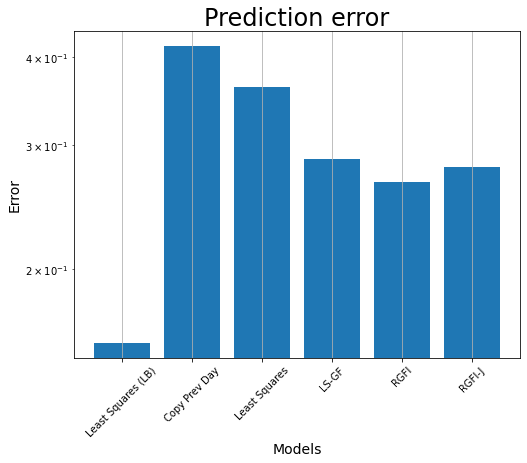

In [114]:
x_ax = np.arange(len(models))
plt.figure(figsize=(8,6))
plt.bar(x_ax, errs_y, log=True)
plt.xticks(x_ax, models, rotation=45)
plt.title("Prediction error", fontsize=24)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.grid()